In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_inline import backend_inline
backend_inline.set_matplotlib_formats("svg")
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor

In [2]:
df=pd.read_excel("./Data Scientist - Recruitment task - Raw data.xlsx",
                         sheet_name="Raw Data")
df.Day=pd.to_datetime(df.Day)
foot_print=df.copy()
foot_print.head()

,Day,Advertising_Spend,Number_of_Visitors,Average_Session_Duration,Page_Load_Time,Day_of_Week,Impressions
0,2021-10-01,28008.521469,19925,3.54,4.91,Friday,140811
1,2021-10-02,20812.773757,33385,1.40,3.00,Saturday,82038
2,2021-10-03,22878.770076,38600,1.33,1.35,Sunday,36693
3,2021-10-04,11876.136172,19424,3.48,3.12,Monday,76526
4,2021-10-05,33387.536319,21196,3.48,1.42,Tuesday,124470


In [3]:
foot_print.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1045 entries, 0 to 1044
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Day                       1045 non-null   datetime64[ns]
 1   Advertising_Spend         1045 non-null   float64       
 2   Number_of_Visitors        1045 non-null   int64         
 3   Average_Session_Duration  1045 non-null   float64       
 4   Page_Load_Time            1045 non-null   float64       
 5   Day_of_Week               1045 non-null   object        
 6   Impressions               1045 non-null   int64         
dtypes: datetime64[ns](1), float64(3), int64(2), object(1)
memory usage: 57.3+ KB


In [4]:
foot_print.shape

(1045, 7)

In [5]:
foot_print.isna().sum()

Day                         0
Advertising_Spend           0
Number_of_Visitors          0
Average_Session_Duration    0
Page_Load_Time              0
Day_of_Week                 0
Impressions                 0
dtype: int64

## Feature engineering

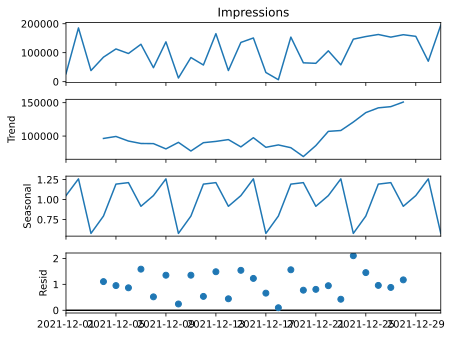

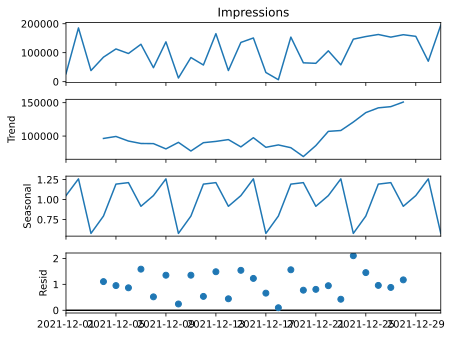

In [6]:
foot_print_fe=foot_print.copy()
day_of_week_dummy=pd.get_dummies(foot_print_fe.Day_of_Week).astype('int64')
foot_print_fe=foot_print.copy().drop(columns=['Day_of_Week'],
                                         axis=1)

foot_print_fe=pd.concat([foot_print_fe,day_of_week_dummy],axis=1)
foot_print_fe.index=foot_print_fe.Day
seasonal_decompose(foot_print_fe[(foot_print_fe.Day.dt.year==2021) & (foot_print_fe.Day.dt.month>=12)].Impressions,model='multiplicative').plot()

In [7]:
foot_print_fe.drop(columns='Day',axis=1,inplace=True)

foot_print_fe['Impressions_lag7']=foot_print_fe.Impressions.shift(7)
foot_print_fe['Impressions_7_day_avg']=foot_print_fe.Impressions.shift(1).rolling(window=7).mean()
foot_print_fe['Advertising_Spend_7_day_avg']=foot_print_fe.Advertising_Spend.shift(1).rolling(window=7).mean()
foot_print_fe['Num_vistitor_7_day_avg']=foot_print_fe.Number_of_Visitors.shift(1).rolling(window=7).mean()
foot_print_fe['Average_Session_Duration_7_day_avg']=foot_print_fe.Average_Session_Duration.shift(1).rolling(window=7).mean()
foot_print_fe['Page_Load_Time_7_day_avg']=foot_print_fe.Page_Load_Time.shift(1).rolling(window=7).mean()
foot_print_fe.dropna(axis=0,inplace=True)
features_droped=['Number_of_Visitors','Average_Session_Duration','Page_Load_Time','Monday']
foot_print_fe.drop(columns=features_droped,axis=1,inplace=True)

In [8]:
train_df=foot_print_fe[foot_print_fe.index<pd.to_datetime('2024-08-1')]

In [9]:
test_df=foot_print_fe[(foot_print_fe.index<=pd.to_datetime('2024-08-10'))&(foot_print_fe.index>=pd.to_datetime('2024-08-1'))]

c:\Users\dutta\.virtualenvs\cash_rewards_task-yYhTm1sl\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\dutta\.virtualenvs\cash_rewards_task-yYhTm1sl\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


np.float64(3894.7935833329975)

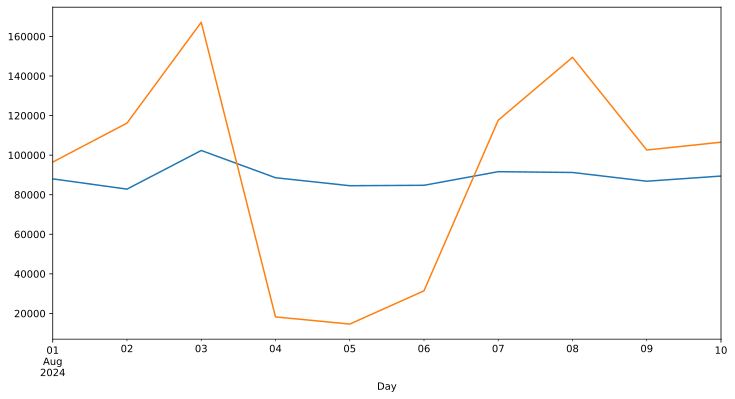

In [10]:
plt.figure(figsize=(12,6))
exog_list=['Impressions_lag7',
           'Advertising_Spend_7_day_avg',
           'Impressions_7_day_avg',
           'Advertising_Spend',
           'Num_vistitor_7_day_avg',
           'Average_Session_Duration_7_day_avg',
           'Page_Load_Time_7_day_avg',
           'Tuesday',
           'Wednesday',
           'Thursday',
           'Friday',
           'Saturday',
           'Sunday']
model=SARIMAX(train_df.Impressions,exog=train_df[exog_list],trend='n',order=(1,0,0),seasonal_order=(1,1,1,7))
model_fit=model.fit()
mae_train=mean_absolute_error(y_true=train_df.Impressions,y_pred=model_fit.predict(exog=train_df[exog_list]))
mae_test=mean_absolute_error(y_true=test_df.Impressions,y_pred=model_fit.forecast(10,exog=test_df[exog_list]))
display(abs(mae_test-mae_train))
model_fit.forecast(10,exog=test_df[exog_list]).plot.line()
test_df.Impressions.plot.line();

In [11]:
X_train,X_test,Y_train,Y_test=train_df.drop(columns='Impressions'),test_df.drop(columns='Impressions'),train_df.Impressions,test_df.Impressions

np.float64(6572.948274922179)

C:\Users\dutta\AppData\Local\Temp\ipykernel_29812\1671174176.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['Forecasted']=model_2.predict(X_test)


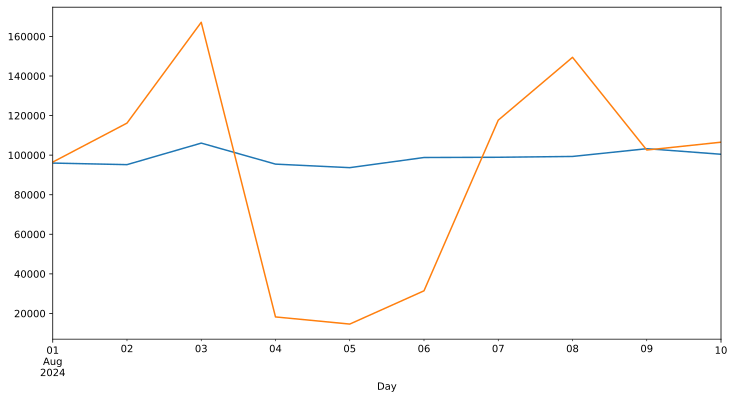

In [12]:
plt.figure(figsize=(12,6))
model_2=LinearRegression()
model_2.fit(X_train,Y_train)

mae_2_train=mean_absolute_error(y_true=Y_train,y_pred=model_2.predict(X_train))
mae_2_test=mean_absolute_error(y_true=Y_test,y_pred=model_2.predict(X_test))
display(abs(mae_2_test-mae_2_train))
test_df['Forecasted']=model_2.predict(X_test)
test_df.Forecasted.plot.line()
test_df.Impressions.plot.line();

np.float64(22990.02303501945)

C:\Users\dutta\AppData\Local\Temp\ipykernel_29812\1712861008.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['Forecasted']=model_2.predict(X_test)


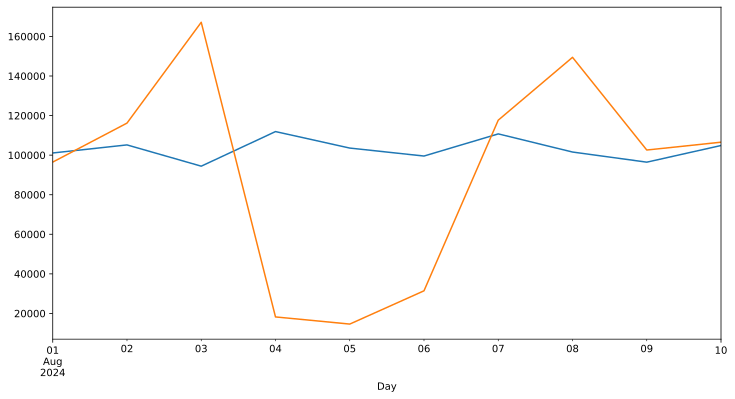

In [13]:
plt.figure(figsize=(12,6))
model_2=RandomForestRegressor()
model_2.fit(X_train,Y_train)

mae_2_train=mean_absolute_error(y_true=Y_train,y_pred=model_2.predict(X_train))
mae_2_test=mean_absolute_error(y_true=Y_test,y_pred=model_2.predict(X_test))
display(abs(mae_2_test-mae_2_train))
test_df['Forecasted']=model_2.predict(X_test)
test_df.Forecasted.plot.line()
test_df.Impressions.plot.line();

np.float64(702.1065232711262)

C:\Users\dutta\AppData\Local\Temp\ipykernel_29812\3758533056.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['Forecasted']=model_2.predict(X_test)


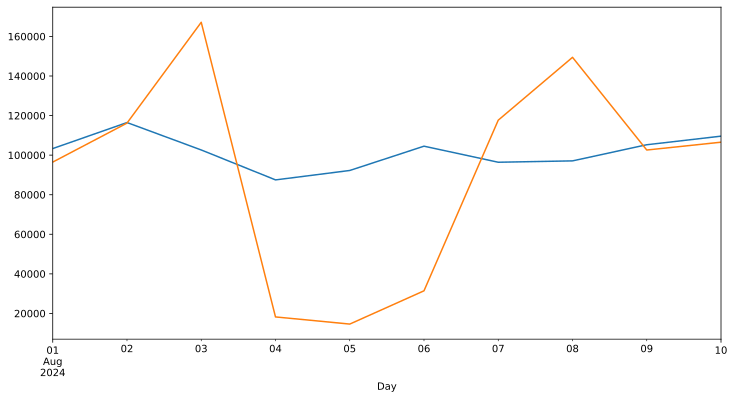

In [14]:
plt.figure(figsize=(12,6))
model_2=GradientBoostingRegressor()
model_2.fit(X_train,Y_train)

mae_2_train=mean_absolute_error(y_true=Y_train,y_pred=model_2.predict(X_train))
mae_2_test=mean_absolute_error(y_true=Y_test,y_pred=model_2.predict(X_test))
display(abs(mae_2_test-mae_2_train))
test_df['Forecasted']=model_2.predict(X_test)
test_df.Forecasted.plot.line()
test_df.Impressions.plot.line();

In [15]:
randon_states={}
for i in range(1,1000):
    model_2=GradientBoostingRegressor(random_state=i)
    model_2.fit(X_train,Y_train)

    mae_2_train=mean_absolute_error(y_true=Y_train,y_pred=model_2.predict(X_train))
    mae_2_test=mean_absolute_error(y_true=Y_test,y_pred=model_2.predict(X_test))
    randon_states[i]=(abs(mae_2_test-mae_2_train))

best_random_state=min(randon_states.items(), key=lambda x: x[1])
best_random_state

(11, np.float64(36.37584782428894))

np.float64(36.37584782428894)

C:\Users\dutta\AppData\Local\Temp\ipykernel_29812\3031804054.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['Forecasted']=gbm_forecast.predict(X_test)


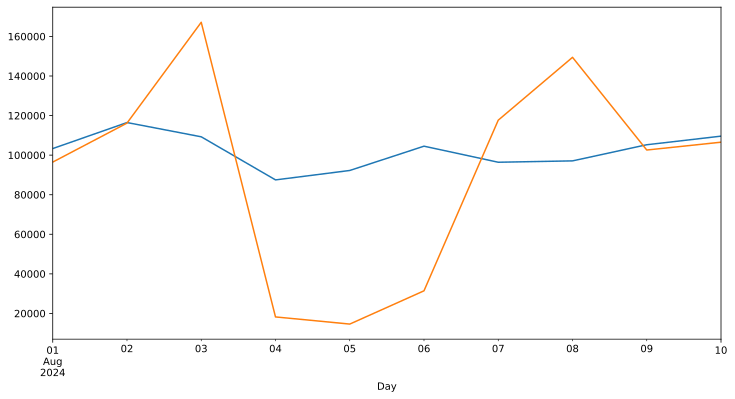

In [17]:
plt.figure(figsize=(12,6))
gbm_forecast=GradientBoostingRegressor(random_state=best_random_state[0])
gbm_forecast.fit(X_train,Y_train)

mae_train=mean_absolute_error(y_true=Y_train,y_pred=gbm_forecast.predict(X_train))
mae_test=mean_absolute_error(y_true=Y_test,y_pred=gbm_forecast.predict(X_test))
display(abs(mae_test-mae_train))
test_df['Forecasted']=gbm_forecast.predict(X_test)
test_df.Forecasted.plot.line()
test_df.Impressions.plot.line();